In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import joblib

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='svevazanettieo1') #così apro il progetto esistente in GEE, non ne sto creando uno nuovo

In [3]:
# Function to convert Earth Engine FeatureCollection to Pandas DataFrame, eliminating the random column
def from_FeatureCollection_to_df(path):
    points = ee.FeatureCollection(path)
    points_ft = points.getInfo()['features']
    points_df = pd.json_normalize(points_ft)
    points_df = points_df.drop(columns=['properties.random'], errors='ignore')
    return points_df

training_points_df = from_FeatureCollection_to_df('projects/svevazanettieo1/assets/Dubai/Dubai_training_indexes')
validation_points_df = from_FeatureCollection_to_df('projects/svevazanettieo1/assets/Dubai/Dubai_validation_indexes')

print('Dataset size: \n')
print('Training set:', training_points_df.shape)
print('Validation set:', validation_points_df.shape)

Dataset size: 

Training set: (1918, 14)
Validation set: (413, 14)


In [4]:
# Extract feature columns (e.g., 'properties.B1', 'properties.B2', etc.)
feature_columns = [col for col in training_points_df.columns if col.startswith('properties.B') or col.startswith('properties.n')]
feature_columns

# Extract features and labels for training
X_train = training_points_df[feature_columns]
y_train = training_points_df['properties.LC']

# Extract features and labels for validation
X_val = validation_points_df[feature_columns]
y_val = validation_points_df['properties.LC']

In [5]:
scaler = MinMaxScaler()

# Normalize data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

joblib.dump(scaler, "scaler.save")

['scaler.save']

In [6]:
N_CLASSES = len(y_train.unique())
y_train = to_categorical(y_train, num_classes=N_CLASSES)
y_val = to_categorical(y_val, num_classes=N_CLASSES)

#qui vogliamo mischiare l'ordine dei dati, altrimenti tutti i primi sono dello stesso tipo, e così via

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch the datasets
train_dataset_batch = train_dataset.shuffle(buffer_size=64).batch(8)
val_dataset_batch = val_dataset.batch(8)

2025-08-28 23:31:29.460663: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-28 23:31:29.461042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-28 23:31:29.461054: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-28 23:31:29.461281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-28 23:31:29.461298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# ANN1

In [7]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

# Compile the model with the specified loss function.
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model
history1 = model1.fit(train_dataset_batch, validation_data=val_dataset_batch, epochs=100)
# Print model summary and save the model
model1.summary()
model1.save('model1.keras')

Epoch 1/100


/opt/anaconda3/envs/Earth_Obs/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-28 23:31:37.756270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6981 - loss: 0.8471 - val_accuracy: 0.4286 - val_loss: 1.5798
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7419 - loss: 0.6134 - val_accuracy: 0.4722 - val_loss: 1.3759
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8405 - loss: 0.4735 - val_accuracy: 0.5133 - val_loss: 1.2060
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8535 - loss: 0.4308 - val_accuracy: 0.5666 - val_loss: 0.9972
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8670 - loss: 0.3946 - val_accuracy: 0.5981 - val_loss: 0.8427
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8895 - loss: 0.3691 - val_accuracy: 0.6174 - val_loss: 0.7136
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8916 - loss: 0.3490 - val_accuracy: 0.6780 - val_loss: 0.6257
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8999 - loss: 0.3289 - val_accuracy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,702 (10.56 KB)

 Trainable params: 900 (3.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,802 (7.04 KB)

# ANN2

In [8]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # metric to monitor
    patience=15,          
    restore_best_weights=True  
)

# Define the callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Watch validation loss
    factor=0.1,             # Drop LR by an order of magnitude (×0.1)
    patience=5,             # Wait 5 epochs with no improvement
    min_lr=1e-5,            # Lower bound on learning rate
    verbose=1
)
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

# Compile the model with the specified loss function.
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model
history2 = model2.fit(train_dataset_batch, validation_data=val_dataset_batch, epochs=250, callbacks=[early_stopping, reduce_lr])
# Print model summary and save the model
model2.summary()
model2.save('model2.keras')

Epoch 1/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7857 - loss: 0.7137 - val_accuracy: 0.4383 - val_loss: 1.9110 - learning_rate: 0.0010
Epoch 2/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8441 - loss: 0.4967 - val_accuracy: 0.4770 - val_loss: 1.6784 - learning_rate: 0.0010
Epoch 3/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8811 - loss: 0.3572 - val_accuracy: 0.5012 - val_loss: 1.7517 - learning_rate: 0.0010
Epoch 4/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8827 - loss: 0.3349 - val_accuracy: 0.5811 - val_loss: 1.1374 - learning_rate: 0.0010
Epoch 5/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8952 - loss: 0.3126 - val_accuracy: 0.5327 - val_loss: 1.2420 - learning_rate: 0.0010
Epoch 6/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9062 - loss: 0.2841 - val_accuracy: 0.5375 - val_loss: 1.0329 - learning_rate: 0.0010
Epoch 7/250
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8989 - l

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,950 (38.87 KB)

 Trainable params: 3,316 (12.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,634 (25.92 KB)

In [9]:
def loss_accuracy_graph(train_loss, val_loss, train_acc, val_acc):
    # Create a figure with two vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

    # Plot training and validation loss
    ax1.plot(train_loss, label='Training loss', alpha=.8)
    ax1.plot(val_loss, label='Validation loss', alpha=.8)
    ax1.set_title('Loss')
    ax1.legend()
    ax1.grid(alpha=.3)

    # Plot training and validation accuracy
    ax2.plot(train_acc, label='Training accuracy', alpha=.8)
    ax2.plot(val_acc, label='Validation accuracy', alpha=.8)
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid(alpha=.3)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()

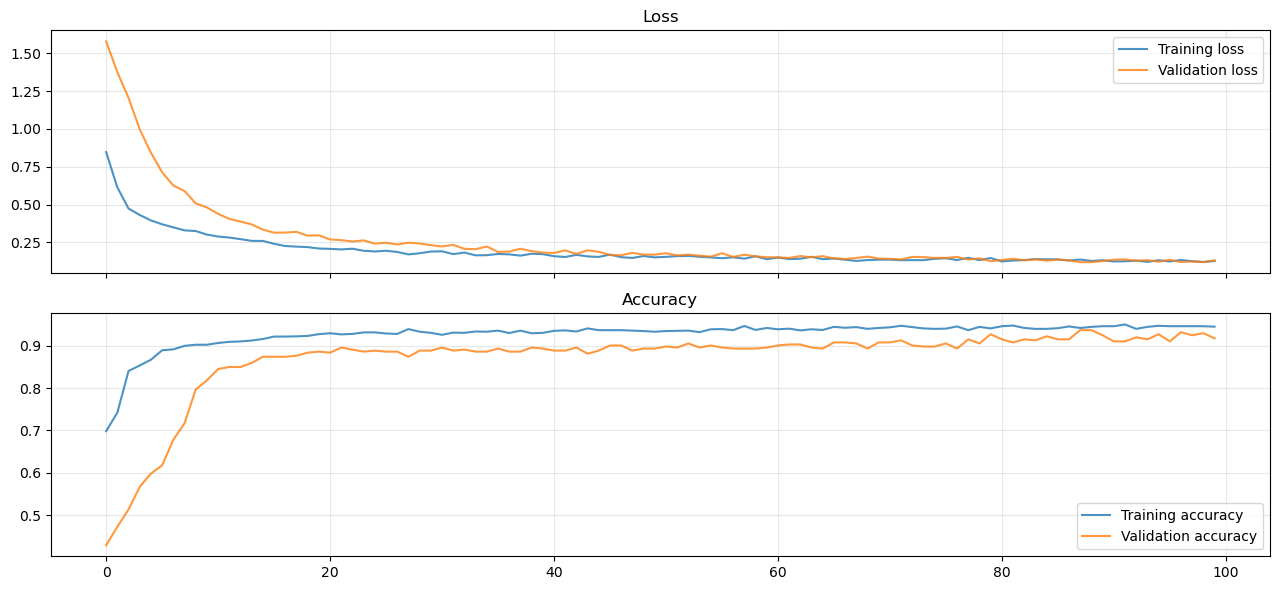

In [10]:
# Get training and validation accuracy and loss
train_acc_1 = history1.history['accuracy']

val_acc_1 = history1.history['val_accuracy']

train_loss_1 = history1.history['loss']

val_loss_1 = history1.history['val_loss']

loss_accuracy_graph(train_loss_1, val_loss_1, train_acc_1, val_acc_1)

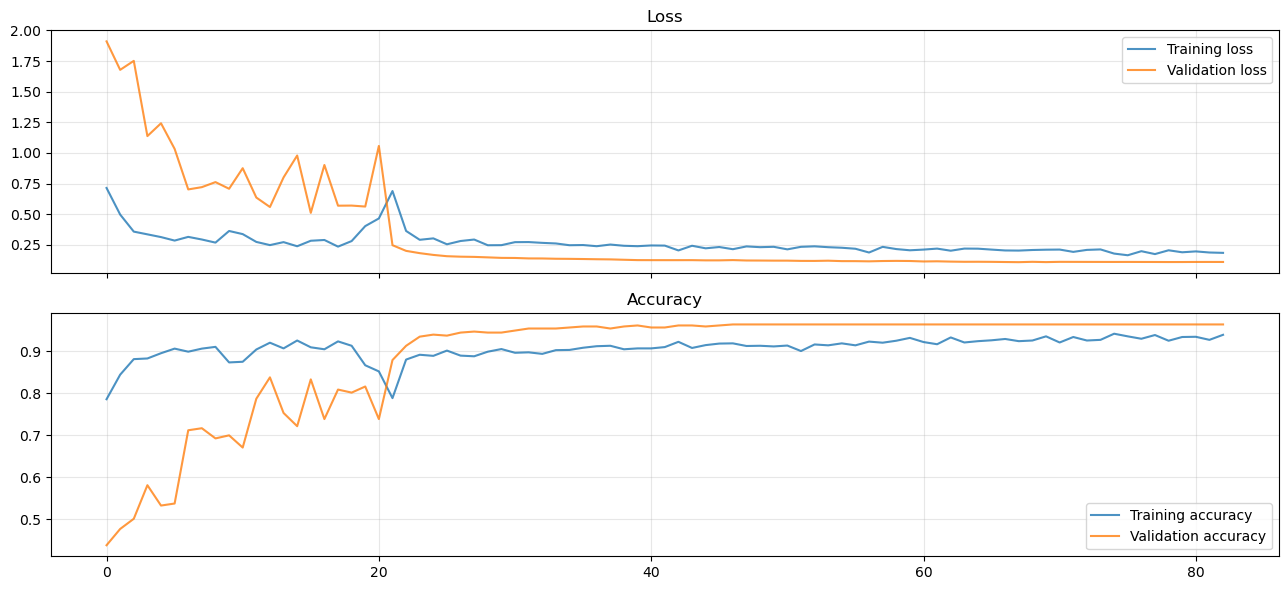

In [11]:
# Get training and validation accuracy and loss
train_acc_2 = history2.history['accuracy']

val_acc_2 = history2.history['val_accuracy']

train_loss_2 = history2.history['loss']

val_loss_2 = history2.history['val_loss']

loss_accuracy_graph(train_loss_2, val_loss_2, train_acc_2, val_acc_2)


In [12]:
y_val_int = np.argmax(y_val, axis=1)

y_pred_ANN1 = model1.predict(X_val)
y_pred_ANN1 = np.argmax(y_pred_ANN1, axis=1)
val_accuracy_ANN1 = accuracy_score(y_val_int, y_pred_ANN1)
cm_ANN1 = confusion_matrix(y_val_int, y_pred_ANN1)

y_pred_ANN2 = model2.predict(X_val)
y_pred_ANN2 = np.argmax(y_pred_ANN2, axis=1)
val_accuracy_ANN2 = accuracy_score(y_val_int, y_pred_ANN2)
cm_ANN2 = confusion_matrix(y_val_int, y_pred_ANN2)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
del model1
del history1
del model2
del history2

# SVM

In [14]:
X_shuffled, y_shuffled = shuffle(X_train, y_train, random_state=42)
X_shuffled_val, y_shuffled_val = shuffle(X_val, y_val, random_state=42)

y_shuffled = np.argmax(y_shuffled, axis=1)
y_shuffled_val = np.argmax(y_shuffled_val, axis=1)

In [15]:
#SVM
# Initialize an SVM with RBF kernel
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Fit model
svm.fit(X_shuffled, y_shuffled)
joblib.dump(svm, "svm_model.pkl")

# Predictions
y_pred_SVM = svm.predict(X_shuffled_val)
cm_SVM = confusion_matrix(y_shuffled_val, y_pred_SVM)
val_accuracy_SVM = accuracy_score(y_shuffled_val, y_pred_SVM)

# Accuracy
print("Validation Accuracy:", val_accuracy_SVM)

Validation Accuracy: 0.9685230024213075


# RF

In [16]:
#Random Forest
# Hyperparameters
n_estimators = 100
max_depth = 10

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, oob_score=True)

clf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced'  # example for 5 classes
)

clf.fit(X_shuffled, y_shuffled)
clf_balanced.fit(X_shuffled, y_shuffled)

y_pred_RF = clf.predict(X_shuffled_val)

y_pred_RF_balanced = clf_balanced.predict(X_shuffled_val)

val_accuracy_RF = accuracy_score(y_shuffled_val, y_pred_RF)
cm_RF = confusion_matrix(y_shuffled_val, y_pred_RF)

val_accuracy_RF_balanced = accuracy_score(y_shuffled_val, y_pred_RF_balanced)
cm_RF_balanced = confusion_matrix(y_shuffled_val, y_pred_RF_balanced)

print("Validation Accuracy RF:", val_accuracy_RF)
print("Validation Accuracy RF (Balanced):", val_accuracy_RF_balanced)

Validation Accuracy RF: 0.9830508474576272
Validation Accuracy RF (Balanced): 0.9878934624697336


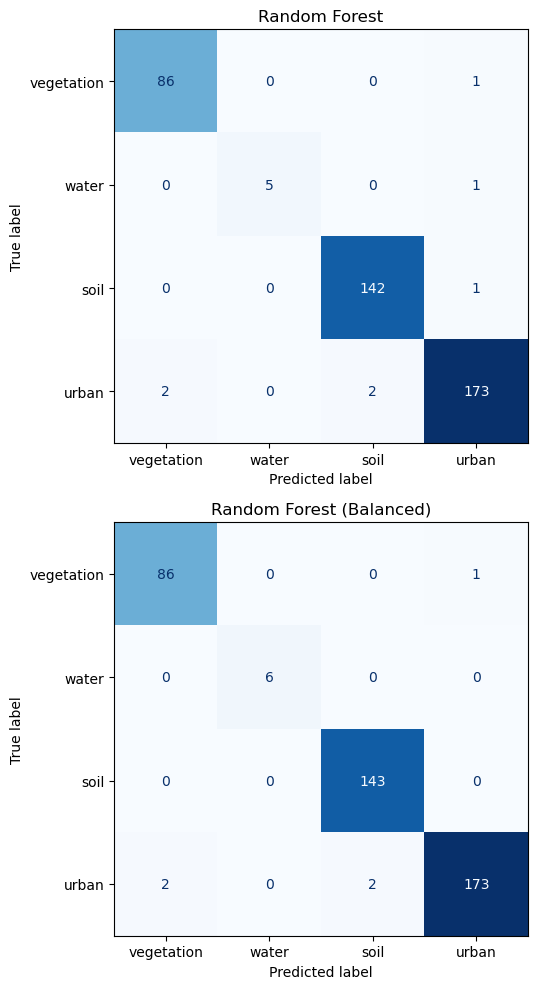

In [17]:
# Suppose you have 4 confusion matrices
cm1 = cm_RF
cm2 = cm_RF_balanced

cms = [cm1, cm2]
titles = ['Random Forest', 'Random Forest (Balanced)']
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 2x2 grid

for i, ax in enumerate(axes.flatten()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=['vegetation','water','soil','urban'])
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)  # use ax
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

# Comparison

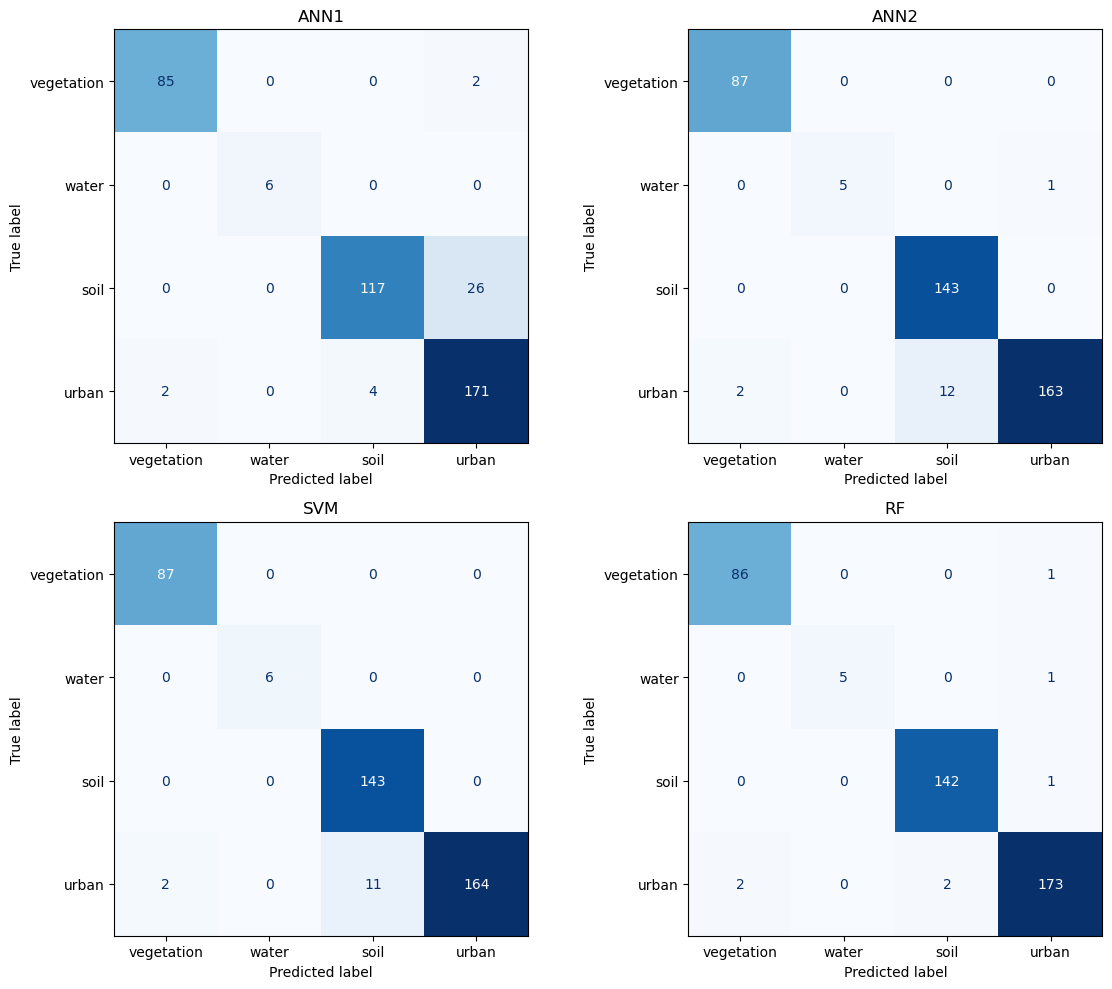

In [19]:
cm1 = cm_ANN1
cm2 = cm_ANN2
cm3 = cm_SVM
cm4 = cm_RF

cms = [cm1, cm2, cm3, cm4]
titles = ['ANN1', 'ANN2', 'SVM', 'RF']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid

for i, ax in enumerate(axes.flatten()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=['vegetation','water','soil','urban'])
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)  # use ax
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()

In [20]:
print("Accuracy")
print("ANN1:", val_accuracy_ANN1)
print("ANN2:", val_accuracy_ANN2)
print("SVM:", val_accuracy_SVM)
print("Random Forest:", val_accuracy_RF)

Accuracy
ANN1: 0.9176755447941889
ANN2: 0.9636803874092009
SVM: 0.9685230024213075
Random Forest: 0.9830508474576272


# Tuning Final Model

In [21]:
y_train_cls = np.argmax(y_train, axis=1)
y_val_cls   = np.argmax(y_val, axis=1)

X = np.vstack((X_train, X_val))
y = np.hstack((y_train_cls, y_val_cls))

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

crossvalidation = StratifiedKFold(n_splits=30, shuffle=True)

# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=50, max_depth=10, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)


print('Random Forest 1')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

#Second model 

# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=100, max_depth=10, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)


print('Random Forest 2')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

#third model

# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=200, max_depth=10, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)


print('Random Forest 3')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

Random Forest 1
Accuracy (CV): 0.990 +/- 0.009
Random Forest 2
Accuracy (CV): 0.990 +/- 0.009
Random Forest 3
Accuracy (CV): 0.991 +/- 0.012


In [22]:
# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

print('Random Forest 1')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

#Second model 

# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=100, max_depth=10, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)


print('Random Forest 2')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

#third model

# Initialize the Random Forest classifier
clf_1 = RandomForestClassifier(n_estimators=100, max_depth=15, oob_score=True)

# Evaluate the model using cross-validation
xval_score = cross_val_score(clf_1, X_shuffled, y_shuffled, cv=crossvalidation)

# Compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)


print('Random Forest 3')  # Print method name
print("========================================")
print(f"Accuracy (CV): {accuracy_mean:.3f} +/- {accuracy_std:.3f}")

Random Forest 1
Accuracy (CV): 0.982 +/- 0.015
Random Forest 2
Accuracy (CV): 0.990 +/- 0.013
Random Forest 3
Accuracy (CV): 0.989 +/- 0.011


In [23]:
# Best Hyperparameters
n_estimators = 100
max_depth = 10

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, oob_score=True)
clf.fit(X_shuffled, y_shuffled)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [24]:
# Save model
joblib.dump(clf, "random_forest_model_train+val.pkl")

['random_forest_model_train+val.pkl']